In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sn
import os
import matplotlib.pyplot as plt

In [2]:
df_keys = ["ndata", "nchains", "nsamples", "comp_time_total", 
           "time/chain_max", "time/chain_min", "time/chain_mean",
           "MC_it_min", "MC_it_max", "MC_it_mean", "MC_it_total",
           "mix_max", "mix_min", "mix_mean",
           "MC_std_err_min", "MC_std_err_max", "MC_std_err_mean",
           "eff_size_min", "eff_size_max", "eff_size_mean",
           "thinning_min", "thinning_max", "thinning_mean",
           "file_size_MB"]
file_keys = ["time",
           "MC_it",
           "components",
           "MC_std_err_min", "MC_std_err_max",
           "eff_size_min", "eff_size_max",
           "thinning_min", "thinning_max"]
    
line_prefix = ["MCMC time",
               "USED COMPONENTS",
               "rel. MC standard error",
               "eff. sample size",
               "needed thinning",
               "Total number of iterations"]

df = pd.DataFrame(columns = df_keys)

In [3]:
def process(i, line, df):
    for prefix in line_prefix:
        #print(prefix)
        #print(line)
        if prefix in line:
            #print("match", line, prefix)

            if prefix == "MCMC time":
                time = int(re.findall('\d+', line)[0])
                # parse secs, mins, hours to seconds
                if "secs" in line:
                    time = time
                elif "mins" in line:
                    time = time*60
                elif "hours":
                    time = time*60*60
                df["time"][i] = time

            if prefix == "USED COMPONENTS":  
                string = re.split(r"\:", line)[-1]
                numbers = [int(num) for num in re.findall(r'[\d]+', string)]
                components = numbers[0]
                if np.isnan(df["components"][i]):
                    df["components"][i] = components

            if prefix == "Total number of iterations":
                numbers = [int(num) for num in re.findall(r'[\d]+', line)]
                remaining = numbers[1]
                if remaining == 0:
                    its_used = numbers[0]
                    df["MC_it"][i] = its_used
                    
            if prefix == "rel. MC standard error":
                string = re.split(r"\:", line)[-1]
                numbers = [float(num) for num in re.findall(r'[\d.]+', string)]
                low_value = numbers[0]
                high_value = numbers[1]
                df["MC_std_err_min"][i] = low_value
                df["MC_std_err_max"][i] = high_value

            if prefix == "eff. sample size":
                string = re.split(r"\:", line)[-1]
                numbers = [int(num) for num in re.findall(r'[\d]+', string)]
                low_value = numbers[0]
                high_value = numbers[1]
                df["eff_size_min"][i] = low_value
                df["eff_size_max"][i] = high_value

            if prefix == "needed thinning":
                string = re.split(r"\:", line)[-1]
                numbers = [int(num) for num in re.findall(r'[\d]+', string)]
                low_value = numbers[0]
                high_value = numbers[1]
                df["thinning_min"][i] = low_value
                df["thinning_max"][i] = high_value

    return df

In [4]:
def get_df(dir_names, log_files, df_keys, file_keys):
    df = pd.DataFrame(columns = df_keys, index = range(len(dir_names)))
    for i in range(len(dir_names)):
        df_dir = pd.DataFrame(columns = file_keys, index = range(len(log_files[i])))
        for j in range(len(log_files[i])):
            filename = f"{dir_names[i]}{log_files[i][j]}"
            with open(filename, 'r') as file:
                while True:
                    line = file.readline()
                    if not line:
                        break
                    # Process line of data
                    df_dir = process(j, line, df_dir)

        df["comp_time_total"][i] = df_dir["time"].sum()
        df["time/chain_max"][i] = df_dir["time"].max()
        df["time/chain_min"][i] = df_dir["time"].min()
        df["time/chain_mean"][i] = df_dir["time"].mean()
        df["MC_it_total"][i] = df_dir["MC_it"].sum()
        df["MC_it_min"][i] = df_dir["MC_it"].min()
        df["MC_it_max"][i] = df_dir["MC_it"].max()
        df["MC_it_mean"][i] = df_dir["MC_it"].mean()
        df["mix_max"][i] = df_dir["components"].max()
        df["mix_min"][i] = df_dir["components"].min()
        df["mix_mean"][i] = df_dir["components"].mean()
        df["MC_std_err_max"][i] = df_dir["MC_std_err_max"].max()
        df["MC_std_err_min"][i] = df_dir["MC_std_err_min"].min()
        df["MC_std_err_mean"][i] = np.mean(df_dir["MC_std_err_max"] - df_dir["MC_std_err_min"])
        df["eff_size_max"][i] = df_dir["eff_size_max"].max()
        df["eff_size_min"][i] = df_dir["eff_size_min"].min()
        df["eff_size_mean"][i] = np.mean(df_dir["eff_size_max"] - df_dir["eff_size_min"])
        df["thinning_max"][i] = df_dir["thinning_max"].max()
        df["thinning_min"][i] = df_dir["thinning_min"].min()
        df["thinning_mean"][i] = np.mean(df_dir["thinning_max"] - df_dir["thinning_min"])
        # File size
        df["file_size_MB"][i] = os.path.getsize(f"{dir_names[i]}learnt.rds")/10**6
    return df

In [21]:
# Setup
vary_n_samples = [20, 40, 80, 160, 320, 640]
const_n_samples = 1200
vary_n_data = [250, 500, 1000, 2000, 2100, 3000, 3600, 4000, 5000, 7000, 10000]
const_n_data = 2000
vary_n_chains = [1, 2, 4, 8, 16]
const_n_chains = 10
polar = False

y_labels = ["red", "blue"]
if polar:
    x_labels = ["r_x", "a_x"]
else:
    x_labels = ["x1", "x2"]
#nsamples = 1200
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
testfile = "x1_x2_grid"

weight_key = f"P({y_labels[1]}|x)"

# vary ndata
if polar:
    vary_n_data_folders = [f"inference/{trainfile}/nsamples-{const_n_samples}_nchains-{const_n_chains}_ndata-{vary_n_data[i]}_POLAR/" for i in range(len(vary_n_data))]
else:
    vary_n_data_folders = [f"inference/{trainfile}/nsamples-{const_n_samples}_nchains-{const_n_chains}_ndata-{vary_n_data[i]}/" for i in range(len(vary_n_data))]
vary_n_data_log_files = [[f"log-{i}.log" for i in range(1, const_n_chains+1)] for j in range(len(vary_n_data))]
vary_n_data_df = get_df(vary_n_data_folders, vary_n_data_log_files, df_keys, file_keys)
vary_n_data_df["ndata"] = vary_n_data
vary_n_data_df["nchains"] = const_n_chains
vary_n_data_df["nsamples"] = const_n_samples
vary_n_data_df["comp_time_total_mins"] = vary_n_data_df["comp_time_total"]/60
print("n_samples")

# vary n_samples, n_chains=1
if polar:
    vary_n_samples_folders = [f"inference/{trainfile}/nsamples-{vary_n_samples[i]}_nchains-{1}_ndata-{const_n_data}_POLAR/" for i in range(len(vary_n_samples))]
else:
    vary_n_samples_folders = [f"inference/{trainfile}/nsamples-{vary_n_samples[i]}_nchains-{1}_ndata-{const_n_data}/" for i in range(len(vary_n_samples))]
vary_n_samples_log_files = [[f"log-{i}.log" for i in range(1, 1+1)] for j in range(len(vary_n_samples))]
vary_n_samples_df = get_df(vary_n_samples_folders, vary_n_samples_log_files, df_keys, file_keys)
vary_n_samples_df["nsamples"] = vary_n_samples
vary_n_samples_df["nchains"] = 1
vary_n_samples_df["ndata"] = const_n_data
print("n_chains")
# vary n_chains
if polar:
    vary_n_chains_folders = [f"inference/{trainfile}/nsamples-{const_n_samples}_nchains-{vary_n_chains[i]}_ndata-{const_n_data}_POLAR/" for i in range(len(vary_n_chains))]
else:
    vary_n_chains_folders = [f"inference/{trainfile}/nsamples-{const_n_samples}_nchains-{vary_n_chains[i]}_ndata-{const_n_data}/" for i in range(len(vary_n_chains))]
vary_n_chains_log_files = [[f"log-{i}.log" for i in range(1, vary_n_chains[j]+1)] for j in range(len(vary_n_chains))]
vary_n_chains_df = get_df(vary_n_chains_folders, vary_n_chains_log_files, df_keys, file_keys)
vary_n_chains_df["nchains"] = vary_n_chains
vary_n_chains_df["nsamples"] = const_n_samples
vary_n_chains_df["ndata"] = const_n_data

n_samples
n_chains


In [22]:
vary_n_data_df[["ndata","comp_time_total_mins"]]

,ndata,comp_time_total_mins
0,250,64.0
1,500,320.0
2,1000,263.0
3,2000,314.0
4,2100,276.0
5,3000,445.0
6,3600,1005.0
7,4000,874.0
8,5000,1162.0
9,7000,3600.0


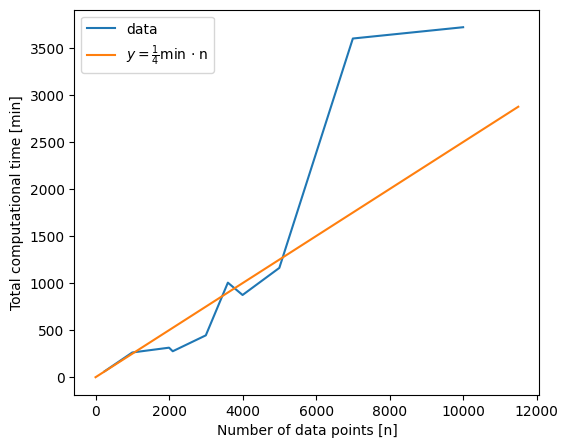

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))

sn.lineplot(data = vary_n_data_df, x = "ndata", y = "comp_time_total_mins", label="data", ax = ax)
ax.set_xlabel("Number of data points [n]")
ax.set_ylabel("Total computational time [min]")
x = np.arange(0, 2**13.5, 500)
#ax.plot(x, x/60, label="y=x")
ax.plot(x, 10*x/40, label=r"$y=\frac{1}{4}$min $\cdot$ n")
ax.legend()

In [11]:
vary_n_samples_df

,ndata,nchains,nsamples,comp_time_total,time/chain_max,time/chain_min,time/chain_mean,MC_it_min,MC_it_max,MC_it_mean,...,MC_std_err_min,MC_std_err_max,MC_std_err_mean,eff_size_min,eff_size_max,eff_size_mean,thinning_min,thinning_max,thinning_mean,file_size_MB
0,2000,1,20,900,900,900,900.0,3600,3600,3600.0,...,0.0141,0.0399,0.0258,629,5010,4381.0,2,9,7.0,0.068629
1,2000,1,40,1260,1260,1260,1260.0,5797,5797,5797.0,...,0.0128,0.0496,0.0368,406,6110,5704.0,2,22,20.0,0.136147
2,2000,1,80,3600,3600,3600,3600.0,28708,28708,28708.0,...,0.0056,0.0494,0.0438,410,31900,31490.0,2,106,104.0,0.271354
3,2000,1,160,1260,1260,1260,1260.0,5113,5113,5113.0,...,0.0141,0.0493,0.0352,411,5040,4629.0,2,19,17.0,0.54152
4,2000,1,320,3600,3600,3600,3600.0,16589,16589,16589.0,...,0.00706,0.0454,0.03834,484,20100,19616.0,2,52,50.0,1.081187
5,2000,1,640,2640,2640,2640,2640.0,10800,10800,10800.0,...,0.00921,0.0299,0.02069,1120,11800,10680.0,2,15,13.0,2.160937


Text(0.5, 1.0, '2 continous variables, 1 discrete, 5 test points')

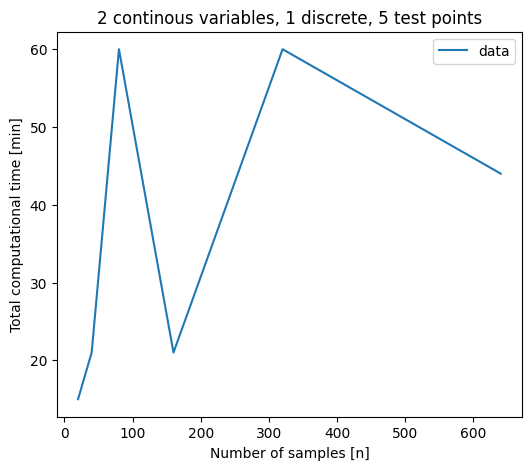

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
vary_n_samples_df["comp_time_total_mins"] = vary_n_samples_df["comp_time_total"]/60
sn.lineplot(data = vary_n_samples_df, x = "nsamples", y = "comp_time_total_mins", label="data", ax = ax)
ax.set_xlabel("Number of samples [n]")
ax.set_ylabel("Total computational time [min]")
ax.legend()
ax.set_title("2 continous variables, 1 discrete, 5 test points")

In [ ]:
vary_n_chains_df

,ndata,nchains,nsamples,comp_time_total,time/chain_max,time/chain_min,time/chain_mean,MC_it_min,MC_it_max,MC_it_mean,...,MC_std_err_min,MC_std_err_max,MC_std_err_mean,eff_size_min,eff_size_max,eff_size_mean,thinning_min,thinning_max,thinning_mean,file_size_MB
0,2000,1,1200,10800,10800,10800,10800.0,53956,53956,53956.0,...,0.00436,0.0235,0.01914,1810,52600,50790.0,2,45,43.0,4.055929
1,2000,2,1200,50400,32400,18000,25200.0,40134,134776,87455.0,...,0.00262,0.0333,0.02947,901,146000,93443.0,2,225,143.5,4.08884
2,2000,4,1200,32400,10800,3600,8100.0,6579,17941,11817.25,...,0.00761,0.0471,0.036568,451,17300,11865.0,2,60,37.0,4.082784
3,2000,8,1200,122400,25200,7200,15300.0,3773,52557,16983.125,...,0.00429,0.05,0.039416,400,54400,16509.75,2,196,61.25,4.086556
4,2000,16,1200,302400,39600,7200,18900.0,3600,67016,14203.8125,...,0.00376,0.05,0.037788,400,70700,15229.4375,2,250,50.375,4.085223


Text(0.5, 1.0, '2 continous variables, 1 discrete, 5 test points')

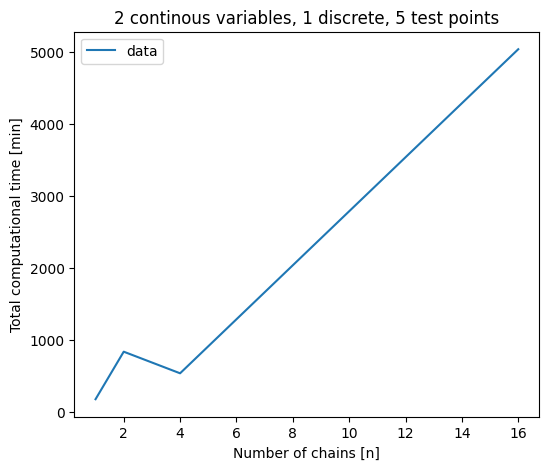

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
vary_n_chains_df["comp_time_total_mins"] = vary_n_chains_df["comp_time_total"]/60
sn.lineplot(data = vary_n_chains_df, x = "nchains", y = "comp_time_total_mins", label="data", ax = ax)
ax.set_xlabel("Number of chains [n]")
ax.set_ylabel("Total computational time [min]")
ax.legend()
ax.set_title("2 continous variables, 1 discrete, 5 test points")

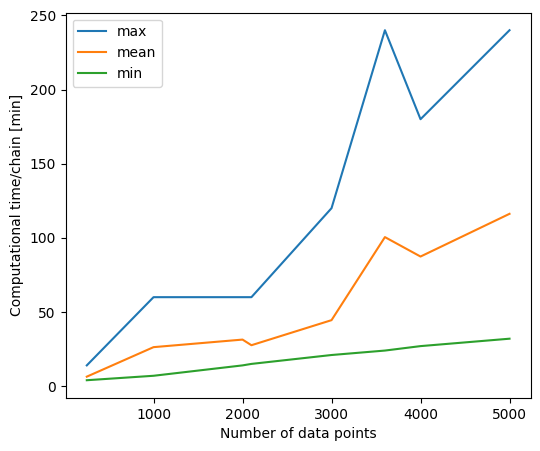

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
vary_n_data_df["time/chain_max_mins"] = vary_n_data_df["time/chain_max"]/60
vary_n_data_df["time/chain_mean_mins"] = vary_n_data_df["time/chain_mean"]/60
vary_n_data_df["time/chain_min_mins"] = vary_n_data_df["time/chain_min"]/60
sn.lineplot(data = vary_n_data_df, x = "ndata", y = "time/chain_max_mins", label="max", ax = ax)
sn.lineplot(data = vary_n_data_df, x = "ndata", y = "time/chain_mean_mins", label="mean", ax = ax)
sn.lineplot(data = vary_n_data_df, x = "ndata", y = "time/chain_min_mins", label="min", ax = ax)
ax.set_xlabel("Number of data points")
ax.set_ylabel("Computational time/chain [min]")
x = np.linspace(0, 2**12, 500)
#ax.plot(x, (3/4)*(1/20)*x, label=r"$y=\frac{3}{80}$x")
ax.legend()

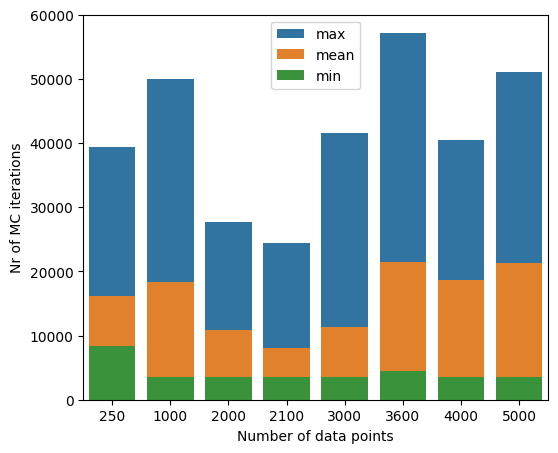

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
sn.barplot(data = vary_n_data_df, x = "ndata", y = "MC_it_max", label="max", ax = ax)
sn.barplot(data = vary_n_data_df, x = "ndata", y = "MC_it_mean", label="mean", ax = ax)
sn.barplot(data = vary_n_data_df, x = "ndata", y = "MC_it_min", label="min", ax = ax)
ax.set_xlabel("Number of data points")
ax.set_ylabel("Nr of MC iterations")

ax.legend()

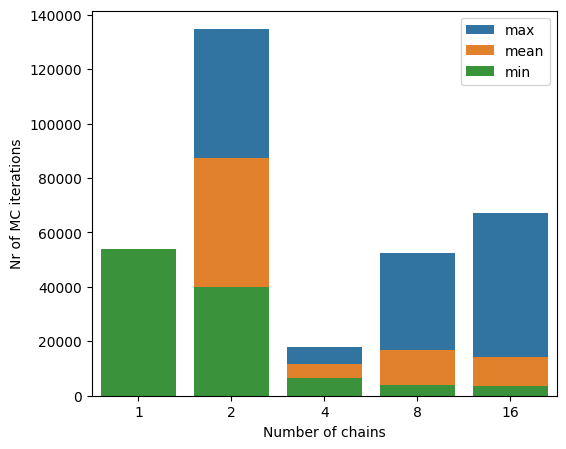

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
sn.barplot(data = vary_n_chains_df, x = "nchains", y = "MC_it_max", label="max", ax = ax)
sn.barplot(data = vary_n_chains_df, x = "nchains", y = "MC_it_mean", label="mean", ax = ax)
sn.barplot(data = vary_n_chains_df, x = "nchains", y = "MC_it_min", label="min", ax = ax)
ax.set_xlabel("Number of chains")
ax.set_ylabel("Nr of MC iterations")

ax.legend()

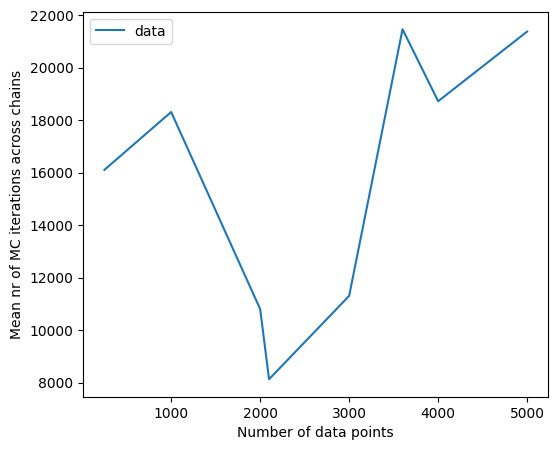

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
sn.lineplot(data = vary_n_data_df, x = "ndata", y = "MC_it_mean", label="data", ax = ax)
ax.set_xlabel("Number of data points")
ax.set_ylabel("Mean nr of MC iterations across chains")
#ax.plot(x, 10*x, label="y=10x")
ax.legend()

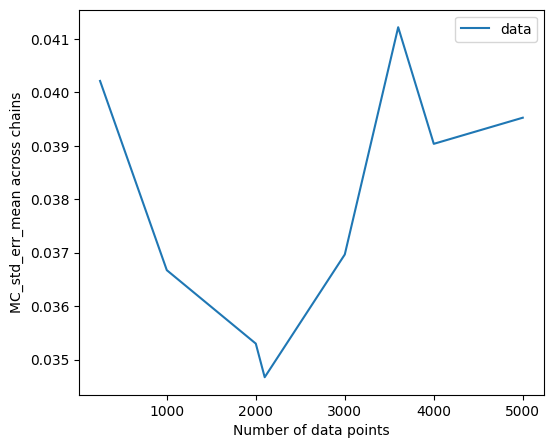

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
sn.lineplot(data = vary_n_data_df, x = "ndata", y = "MC_std_err_mean", label="data", ax = ax)
ax.set_xlabel("Number of data points")
ax.set_ylabel("MC_std_err_mean across chains")
#x = np.arange(0, 2**12, 500)
#ax.plot(x, x, label="y=x")
#ax.plot(x, 10*x, label="y=10x")
ax.legend()

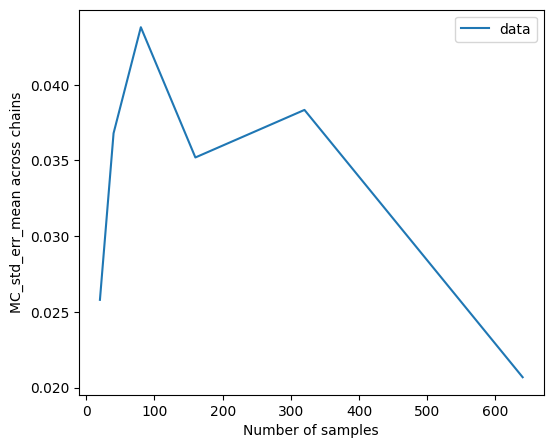

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
sn.lineplot(data = vary_n_samples_df, x = "nsamples", y = "MC_std_err_mean", label="data", ax = ax)
ax.set_xlabel("Number of samples")
ax.set_ylabel("MC_std_err_mean across chains")
ax.legend()

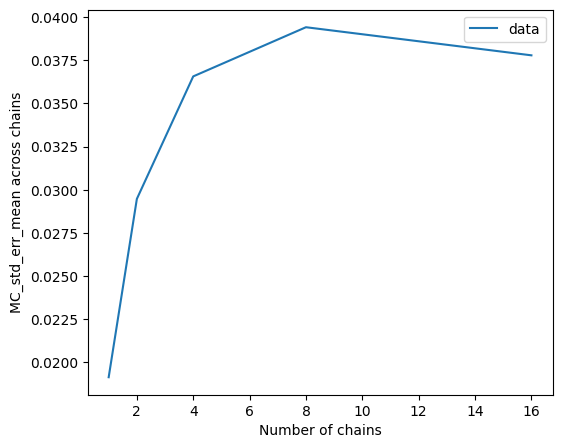

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
sn.lineplot(data = vary_n_chains_df, x = "nchains", y = "MC_std_err_mean", label="data", ax = ax)
ax.set_xlabel("Number of chains")
ax.set_ylabel("MC_std_err_mean across chains")
ax.legend()